In [2]:
%load_ext autoreload
%autoreload 2

# Cell 1: Imports and Initial Setup
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.cluster import SpectralClustering
import warnings
from brancharchitect.io import read_newick
from brancharchitect.distances import (
    calculate_matrix_distance,
    weighted_robinson_foulds_distance,
    robinson_foulds_distance,
)
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Set default renderer for Plotly
pio.renderers.default = "notebook"  # Use "browser" if you prefer to open plots in a web browser
# Ensure inline plotting in Jupyter notebook
%matplotlib inline

In [3]:

def plot_consecutive_distances(df: pd.DataFrame, distance_metric: str, ax, title=None):
    """
    Plot distances between consecutive trees as a line plot.
    """
    df_consecutive = df[df["Tree2"] == df["Tree1"] + 1]
    df_consecutive = df_consecutive.sort_values(by="Tree1")

    ax.plot(
        df_consecutive["Tree1"],
        df_consecutive[distance_metric],
        marker="o",
        linestyle="-",
    )
    if not title:
        title = f"Consecutive Distances ({distance_metric})"
    ax.set_title(title)
    ax.set_xlabel("Tree Index")
    ax.set_ylabel(f"{distance_metric} Distance")
    ax.grid(True)


def plot_distance_matrix(distance_matrix, ax, title="Distance Matrix"):
    """
    Plot the distance matrix as a heatmap.
    """
    sns.heatmap(distance_matrix, cmap="viridis", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Tree Index")
    ax.set_ylabel("Tree Index")


def perform_clustering(distance_matrix, n_clusters=3):
    """
    Perform spectral clustering on the distance matrix.
    """
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=42,
    )
    # For precomputed affinity, we need to convert the distance matrix to a similarity matrix
    similarity_matrix = np.exp(-distance_matrix / np.std(distance_matrix))
    cluster_labels = clustering.fit_predict(similarity_matrix)
    return cluster_labels


def perform_umap(distance_matrix, n_components=3, n_neighbors=15, min_dist=0.1):
    """
    Perform UMAP dimensionality reduction on the distance matrix.
    """
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="precomputed",
        random_state=42,
        spread=1.0,
    )
    embedding = umap_model.fit_transform(distance_matrix)
    return embedding


def create_3d_scatter_plot(embedding, tree_indices, labels, title, method_name):
    """
    Create a 3D scatter plot for the embedding.
    """
    # Use Plotly for interactive 3D plotting
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode="markers",
                marker=dict(
                    size=5,
                    color=labels,
                    colorscale="Viridis",
                    opacity=0.8,
                    colorbar=dict(title="Cluster"),
                ),
                text=[f"Tree Index: {idx}" for idx in tree_indices],
                hoverinfo="text",
            )
        ]
    )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=f"{method_name} Dimension 1",
            yaxis_title=f"{method_name} Dimension 2",
            zaxis_title=f"{method_name} Dimension 3",
        ),
        width=800,
        height=600,
    )

    fig.show()
    

def plot_component_distance_matrix(distance_matrix, title="Component Distance Matrix"):
    """
    Plot the component distance matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrix, cmap="viridis")
    plt.title(title)
    plt.xlabel("Tree Index")
    plt.ylabel("Tree Index")
    plt.show()

def plot_component_consecutive_distances(df_distances, ax=None, title=None):
    """
    Plot distances between consecutive trees as a line plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    df_consecutive = df_distances[df_distances["Tree2"] == df_distances["Tree1"] + 1]
    df_consecutive = df_consecutive.sort_values(by="Tree1")
    ax.plot(
        df_consecutive["Tree1"],
        df_consecutive["ComponentDistance"],
        marker="o",
        linestyle="-",
    )
    if not title:
        title = "Consecutive Component Distances"
    ax.set_title(title)
    ax.set_xlabel("Tree Index")
    ax.set_ylabel("Component Distance")
    ax.grid(True)
    if ax is None:
        plt.show()

def plot_component_umap_3d(embedding, cluster_labels, title="UMAP Embedding (Component Distance)"):
    """
    Create a 3D scatter plot for the UMAP embedding of component distances.
    """
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode="markers",
                marker=dict(
                    size=5,
                    color=cluster_labels,
                    colorscale="Viridis",
                    opacity=0.8,
                    colorbar=dict(title="Cluster"),
                ),
                text=[f"Tree {i+1}" for i in range(embedding.shape[0])],
                hoverinfo="text",
            )
        ]
    )
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            zaxis_title="UMAP Dimension 3",
        ),
        width=800,
        height=600,
    )
    fig.show()


In [6]:
input_file = "./data/six_taxa_all_permutations.newick"  # Update with your Newick file path
# Read trees
print("Reading phylogenetic trees...")
trees = read_newick(input_file)
trees = trees
num_trees = len(trees)
print(f"Number of trees read: {num_trees}")
# Cell 4: Analysis Preparation

# List of distance metrics to compare
distance_metrics = ["rf", "rfw"]  # 'rfw' will be computed using brancharchitect

# Initialize dictionaries to store data
distance_dataframes = {}
distance_matrices = {}
cluster_labels_dict = {}
embeddings_umap = {}

Reading phylogenetic trees...
Number of trees read: 945


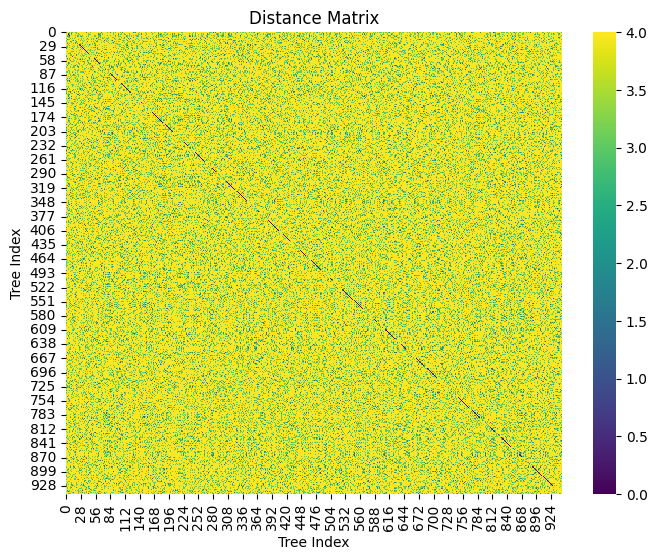

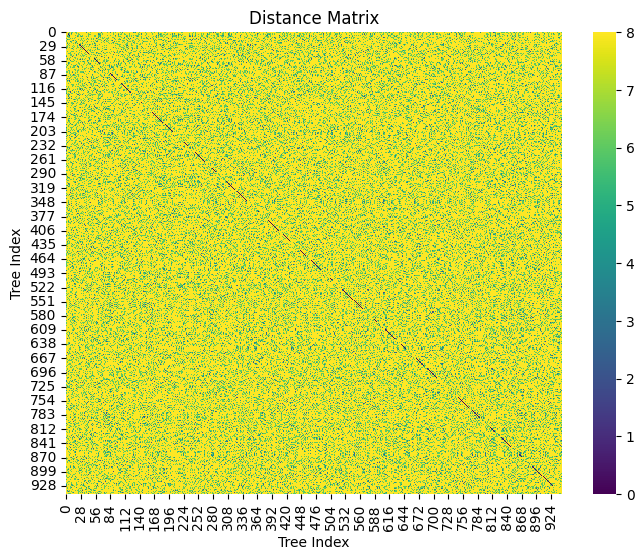

In [7]:
# Cell 5: Main Analysis Loop
for idx, distance_metric in enumerate(distance_metrics):
    # For 'rfw' and 'rf', compute distance matrix using brancharchitect
    if distance_metric == "rfw":
         distance_matrix = calculate_matrix_distance(
             trees, weighted_robinson_foulds_distance
         )
    if distance_metric == "rf":
        distance_matrix = calculate_matrix_distance(
            trees, robinson_foulds_distance
        )

    distance_matrix = np.array(distance_matrix)  # Convert to numpy array
    distance_matrices[distance_metric] = distance_matrix

        # Create a DataFrame for plotting
    tree_indices = np.arange(1, num_trees + 1)
    df_distances = pd.DataFrame(
        {
            "Tree1": np.repeat(tree_indices, num_trees),
            "Tree2": np.tile(tree_indices, num_trees),
            distance_metric: distance_matrix.flatten(),
        }
    )
    distance_dataframes[distance_metric] = df_distances

    plt.figure(figsize=(8, 6))
    plot_distance_matrix(
        distance_matrix,
        ax=plt.gca(),
    )
    plt.show()

    # Step 6: Perform clustering
    cluster_labels = perform_clustering(distance_matrix, n_clusters=3)
    cluster_labels_dict[distance_metric] = cluster_labels


    # UMAP Embedding
    embedding_umap = perform_umap(distance_matrix, n_components=3)
    embeddings_umap[distance_metric] = embedding_umap

    create_3d_scatter_plot(
        embedding_umap,
        tree_indices=tree_indices,
        labels=cluster_labels,
        method_name="UMAP",
        title=f"UMAP Embedding ({distance_metric})",
    )

In [9]:
import numpy as np
import pandas as pd
from brancharchitect.io import read_newick
from brancharchitect.component_distance import (
    extract_components,
    component_distance,
)

def analyze_component_distances(
    input_file,
    weighted=False,
    n_clusters=3,
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
):
    """
    Analyze component-based distances between trees using component_distance.py.

    Args:
        input_file (str): Path to Newick file.
        weighted (bool): Use weighted component distances.
        n_clusters (int): Number of clusters for spectral clustering.
        n_components (int): UMAP embedding dimensions.
        n_neighbors (int): UMAP n_neighbors.
        min_dist (float): UMAP min_dist.

    Returns:
        dict: Results including distance matrix, clusters, embedding, and DataFrame.
    """
    # Read trees
    trees = read_newick(input_file)
    num_trees = len(trees)
    print(f"Read {num_trees} trees.")

    # Extract all unique components
    components = extract_components(trees)
    print(f"Extracted {len(components)} unique components.")

    # Compute component distance matrix (mean over all components for each tree pair)
    distance_matrix = np.zeros((num_trees, num_trees))
    for i in range(num_trees):
        for j in range(num_trees):
            if i == j:
                distance_matrix[i, j] = 0.0
            else:
                dists = component_distance(trees[i], trees[j], components, weighted=weighted)
                distance_matrix[i, j] = np.mean(dists) if dists else 0.0

    # DataFrame for distances
    tree_indices = np.arange(1, num_trees + 1)
    df_distances = pd.DataFrame(
        {
            "Tree1": np.repeat(tree_indices, num_trees),
            "Tree2": np.tile(tree_indices, num_trees),
            "ComponentDistance": distance_matrix.flatten(),
        }
    )

    # Clustering
    similarity_matrix = np.exp(-distance_matrix / np.std(distance_matrix))
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=42,
    )
    cluster_labels = clustering.fit_predict(similarity_matrix)

    # UMAP embedding
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="precomputed",
        random_state=42,
        spread=1.0,
    )
    embedding = umap_model.fit_transform(distance_matrix)

    return {
        "distance_matrix": distance_matrix,
        "distance_dataframe": df_distances,
        "cluster_labels": cluster_labels,
        "embedding_umap": embedding,
        "components": components,
    }

Read 945 trees.
Extracted 57 unique components.


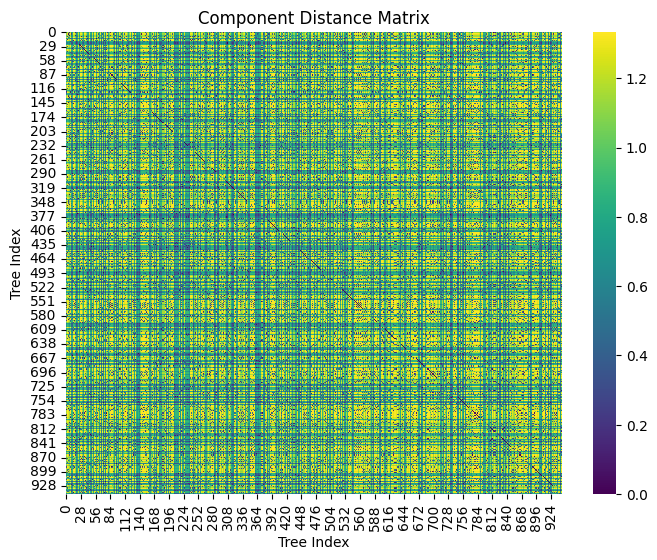

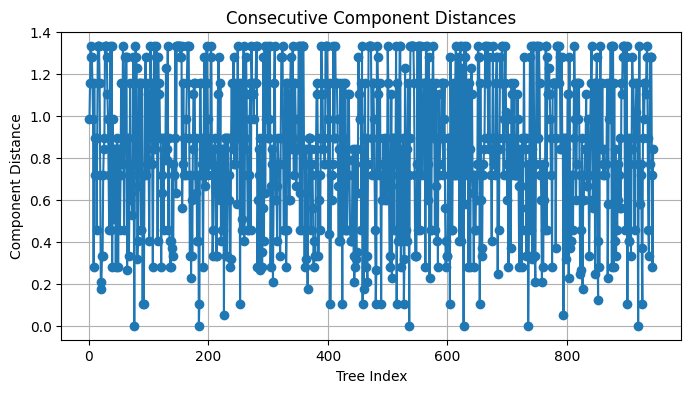

In [ ]:

results = analyze_component_distances(
    input_file="./data/six_taxa_all_permutations.newick",
    weighted=False,
    n_clusters=3,
    n_components=3,
)

plot_component_distance_matrix(results["distance_matrix"])
plot_component_consecutive_distances(results["distance_dataframe"])
plot_component_umap_3d(results["embedding_umap"], results["cluster_labels"])

In [ ]:
#(O,((((B2,C1),(C2,X)),Y),B1));
#(O,(((B2,C1),((B1,C2),Y)),X));
#(O,(((((C2,X),B1),C1),Y),B2));

In [ ]:
results = analyze_component_distances(
    input_file="./data/trimmed_sequences_window_1000_250_GTR/best_trees.newick",
    weighted=False,
    n_clusters=3,
    n_components=3,
)
plot_component_distance_matrix(results["distance_matrix"])
plot_component_consecutive_distances(results["distance_dataframe"])
plot_component_umap_3d(results["embedding_umap"], results["cluster_labels"])

Read 604 trees.
Extracted 8838 unique components.


KeyboardInterrupt: 